In [89]:
# Tutti gli import necessari per il notebook
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # Permetti import da root progetto

import torch
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import faiss

from functions.utils import diagnose_gpu_cuda , check_cuda_availability , get_device

In [90]:
# Importa le librerie fondamentali
np.random.seed(42)
torch.manual_seed(42)

# Imposta tema scuro per matplotlib
plt.style.use('dark_background')

In [91]:
diagnose_gpu_cuda()
    

=== DIAGNOSI GPU/CUDA ===
Versione Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Versione PyTorch: 2.5.1+cu121

torch.cuda.is_available(): True
CUDA device count: 1
  Device 0: NVIDIA GeForce RTX 3060 Ti
  Memory: 8.0 GB

CUDA version compilata in PyTorch: 12.1
PyTorch compilato con CUDA: True

nvidia-smi output:
Wed Sep 10 17:19:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.57                 Driver Version: 576.57         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+===

In [92]:
# Funzione per reinstallare PyTorch con supporto CUDA (se necessario)


# reinstall_pytorch_cuda()

In [93]:
check_cuda_availability()

🔍 VERIFICA FINALE DOPO REINSTALLAZIONE:
PyTorch version: 2.5.1+cu121
CUDA available: True
✅ SUCCESS! GPU rilevata: NVIDIA GeForce RTX 3060 Ti
CUDA version: 12.1
GPU memory: 8.0 GB
✅ Test allocazione GPU: OK (cuda:0)


In [94]:


# Utilizza la funzione per determinare il device
device = get_device()



Using device: cuda (NVIDIA GeForce RTX 3060 Ti)


In [95]:
# Definisci MVTecDataset all'inizio del modulo principale
class MVTecDataset(torch.utils.data.Dataset):
    def __init__(self, category, train=True, transform=None):
        self.transform = transform
        self.train = train
        path = os.path.join(".dataset/mvtecad", category, "train" if train else "test")
        self.good_path = os.path.join(path, "good")
        self.image_paths = []
        self.labels = []
        self.subfolders = []

        if train:
            # Solo immagini good per il training
            self.image_paths = [os.path.join(self.good_path, f) for f in os.listdir(self.good_path) 
                                if f.endswith(('.png', '.jpg', '.jpeg'))]
        else:
            # Per il test: crea sottocartelle per ogni tipo (comprese good)
            for defect_type in os.listdir(path):
                defect_path = os.path.join(path, defect_type)
                if os.path.isdir(defect_path):
                    files = [f for f in os.listdir(defect_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
                    for f in files:
                        self.image_paths.append(os.path.join(defect_path, f))
                        self.labels.append(defect_type)
                        self.subfolders.append(defect_type)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.train:
            return img
        else:
            # Restituisci anche la sottocartella (defect_type) e il nome file
            file_name = os.path.basename(self.image_paths[idx])
            defect_type = self.subfolders[idx]
            return img, defect_type, file_name

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Modello convoluzionale
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 25, kernel_size=5 , padding=2 , padding_mode='replicate')  # Mantieni dimensioni
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(25, 50, kernel_size=3, padding=1, padding_mode='replicate') 
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(50, 75, kernel_size=3, padding=1, padding_mode='replicate')
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(75, 100, kernel_size=3, padding=1, padding_mode='replicate')
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.conv1(x))  # 25x256x256
        x = self.relu2(self.conv2(x))  # 50x256x256
        x = self.relu3(self.conv3(x))  # 75x256x256
        x = self.relu4(self.conv4(x))  # 100x256x256
        return x

In [96]:
# Funzioni di supporto
def extract_compact_patches(
    features: torch.Tensor, 
    patch_size=3, 
    reduction='mean', 
    stride=1, 
    padding=0
    ) -> torch.Tensor:
    """
    Estrae patch da una feature map 4D usando sliding window (simile a una convoluzione), con supporto per stride e padding.

    Args:
        features: torch.Tensor di shape (batch, channels, height, width)
        patch_size: dimensione della patch quadrata (es: 5 -> 5x5)
        reduction: Metodo di riduzione ('mean' per media, 'max' per massimo, o altro)
        stride: Passo della finestra (default=1)
        padding: Padding da applicare ai bordi (default=0)

    Returns:
        patches_reduced: torch.Tensor di shape (num_patches_totali, channels)

    Notes:
        - Ogni patch viene ridotta a un vettore 1D per canale (utile per clustering o altre analisi).
        - La funzione restituisce un array 2D (num_patches_totali, channels).

    Examples:
        # Esempio con immagine 4x4 a 3 canali
        img = torch.arange(4*4*3).reshape(1,3,4,4).float()
        print("Input shape:", img.shape)
        print("Input[0,0]:\n", img[0,0])
        patches = extract_compact_patches(img, patch_size=2, stride=2)
        print("Patches shape:", patches.shape)  # (4, 3)
        print("Patches:\n", patches)
        # Ogni riga di patches è la media dei valori di una patch 2x2 per ogni canale

        # Esempio con feature map (2, 3, 16, 16)
        features = torch.randn(2, 3, 16, 16)
        patches = extract_compact_patches(features, patch_size=5, stride=2)
        print(patches.shape)  # (num_patches_totali, 3)
        print(patches[0])     # Vettore 1D di lunghezza 3 (media di ogni canale)
        print(patches[:5])    # Prime 5 patch
        print(patches.mean(dim=0))  # Media globale per canale
    """
    # Applica padding se richiesto
    if padding > 0:
        features = torch.nn.functional.pad(features, (padding, padding, padding, padding))

    batch_size, channels, height, width = features.shape

    # Estrai patch con unfold su height e width
    patches = features.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    # patches shape: (batch, channels, num_patches_h, num_patches_w, patch_size, patch_size)

    # Porta tutte le patch in una sola dimensione
    patches = patches.contiguous().view(batch_size, channels, -1, patch_size, patch_size)  # (batch, channels, num_patches, patch_size, patch_size)

    # Calcola la media su ogni patch per ogni canale
    # Risultato: (batch, channels, num_patches)
    patches_reduced = patches.mean(dim=[3, 4])

    # Porta la dimensione dei canali in fondo: (batch, num_patches, channels)
    patches_reduced = patches_reduced.permute(0, 2, 1)

    # Unisci tutti i batch in una sola dimensione: (num_patches_totali, channels)
    patches_reduced = patches_reduced.reshape(-1, channels)

    return patches_reduced

Dimensioni immagine: (256, 256, 3)


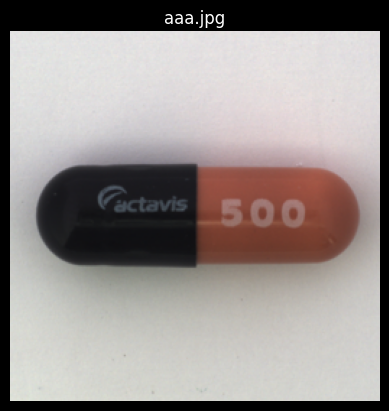

In [97]:
# Carica l'immagine
good_image_path = "../002.png"
good_img = Image.open(good_image_path).resize((256, 256))
# Plotta l'immagine
plt.imshow(good_img)
print(f"Dimensioni immagine: {np.asarray(good_img).shape}")
plt.title("aaa.jpg")
plt.axis('off')
plt.show()

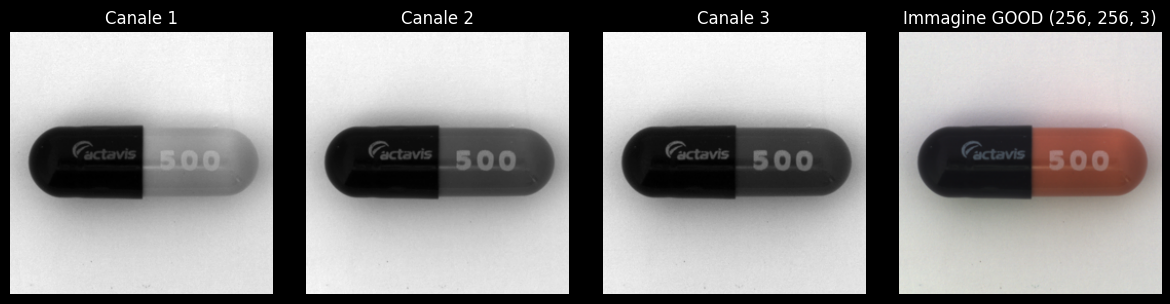

In [98]:
# Convert the PIL.Image object to a NumPy array
good_img_np = np.asarray(good_img)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(3):
    axs[i].imshow(good_img_np[..., i], cmap='gray')
    axs[i].set_title(f'Canale {i+1}')
    axs[i].axis('off')
axs[3].imshow(good_img_np)
axs[3].set_title('RGB')
axs[3].axis('off')
plt.tight_layout()
plt.title(f"Immagine GOOD {good_img_np.shape}")
plt.axis('off')
plt.show()

In [99]:
patch_size = 25
stride = 1
padding = 0
reduction = 'mean'

# Inizializza il modello di feature extraction
model = FeatureExtractor()
model.to(device)
model.eval()

# Prepara l'immagine come batch torch.Tensor (1, C, H, W)
img_tensor = torch.from_numpy(good_img_np.astype(np.float32)).permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    features = model(img_tensor)
    patches = extract_compact_patches(features, patch_size=patch_size, stride=stride, padding=padding, reduction=reduction)
    all_good_patches = patches.cpu()

patch_height = np.sqrt(all_good_patches.shape[0]).astype(int)
patch_width = patch_height

print(f"Total patches extracted: {len(all_good_patches)}")
print(f"Each patch is a vector of length: {all_good_patches.shape[1]} (number of channels)")
print(f"Each feature image has a shape of: {patch_height} * {patch_width} (height x width)")

Total patches extracted: 53824
Each patch is a vector of length: 100 (number of channels)
Each feature image has a shape of: 232 * 232 (height x width)


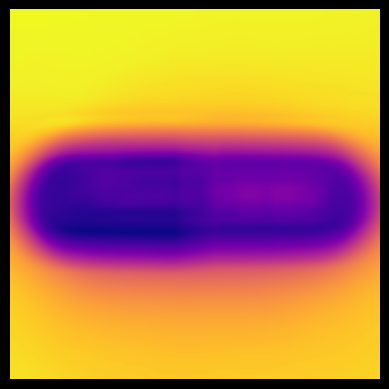

In [100]:
id_pic =26  # Indice dell'immagine da visualizzare
pic = []
for channel in all_good_patches:
    pic.append(channel[id_pic])
pic = np.array(pic).reshape(patch_height, patch_width)  
plt.axis('off')
plt.imshow(pic, cmap='plasma')

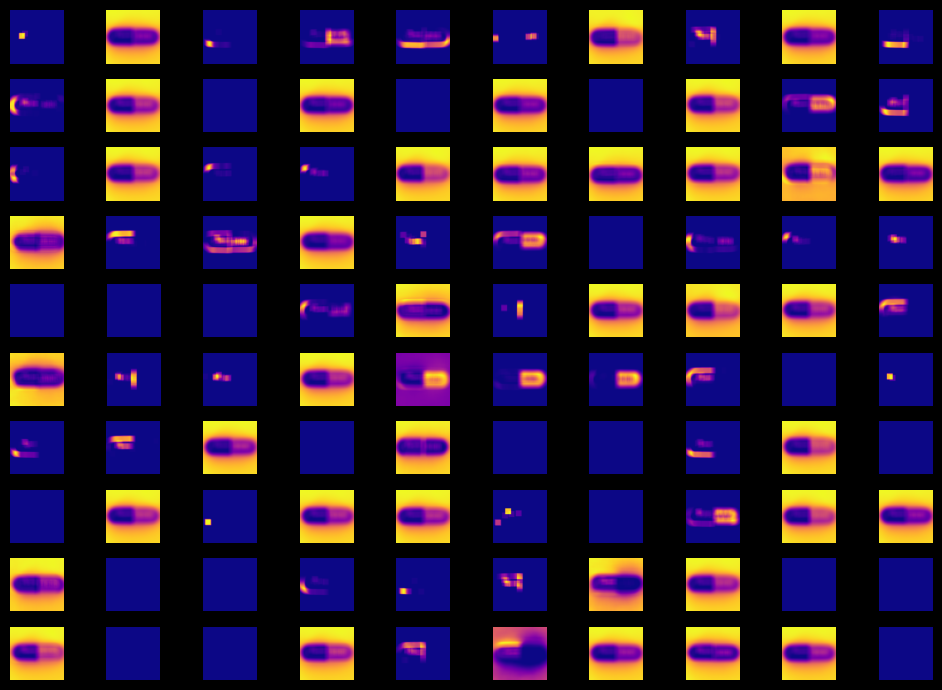

In [101]:
def generate_images_from_patches_boosted(all_patches, patch_height, patch_width):
    """
    Genera immagini dai patch e le ridimensiona utilizzando PyTorch per ottimizzare le operazioni.

    Args:
        all_patches (torch.Tensor): Tensor contenente tutti i patch di dimensione (num_patches, channels).
        patch_height (int): Altezza di ciascun patch.
        patch_width (int): Larghezza di ciascun patch.

    Returns:
        torch.Tensor: Tensor contenente le immagini ridimensionate di dimensione (num_images, patch_height, patch_width).
    """
    # Reshape diretto usando PyTorch per evitare loop
    num_patches, channels = all_patches.shape
    num_images = channels
    reshaped_images = all_patches.T.reshape(num_images, patch_height, patch_width)
    return reshaped_images

# Generate images
fig, axs = plt.subplots(10, 10, figsize=(10, 7))
axs = axs.flatten()
images = generate_images_from_patches_boosted(all_good_patches, patch_height, patch_width)

# Display the patches
for i, img in enumerate(images):
    im = axs[i].imshow(img, cmap='plasma')
    axs[i].axis('off')
    
plt.tight_layout()
plt.show()

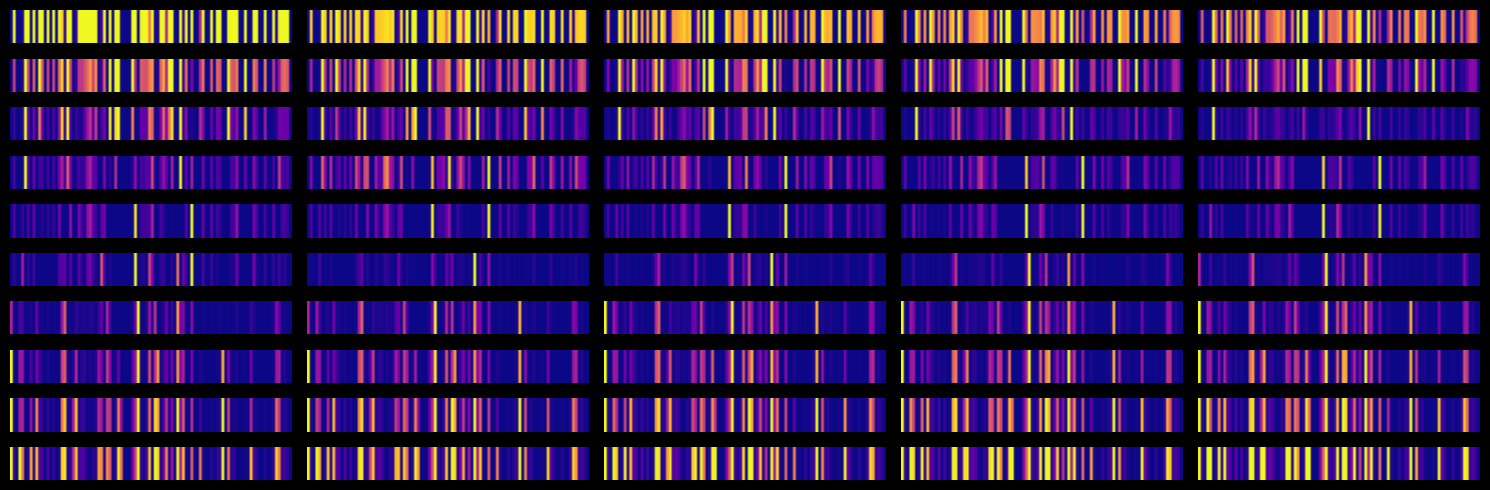

In [102]:
# Assumendo che all_patches sia un torch.Tensor, lo convertiamo in numpy
patches_np = all_good_patches.cpu().numpy()

# Numero di righe e colonne nella griglia
num_rows = 10
num_cols = 5
offset = len(all_good_patches)//2 + 240 # Offset per selezionare patch diverse

# Seleziona le prime (num_rows * num_cols) patch
selected_patches = patches_np[offset : num_cols * num_rows + offset]

# Calcola il minimo e il massimo per ogni colonna (indice)
col_min = selected_patches.min(axis=0)
col_max = selected_patches.max(axis=0)

# Evita la divisione per zero
range_col = col_max - col_min
range_col[range_col == 0] = 1  # Se il range è 0, impostalo a 1 per evitare errori

# Normalizza ogni elemento relativamente alla colonna
normalized_patches = (selected_patches - col_min) / range_col

# Crea la figura e gli assi
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5))


# Itera sulle patch selezionate e sugli assi
for i, patch in enumerate(normalized_patches):
    row = i // num_cols
    col = i % num_cols
    
    # Reshape della patch in una matrice 1x100
    patch_reshaped = patch.reshape(1, -1)
    
    # Mostra la heatmap
    axs[row, col].imshow(patch_reshaped, cmap='plasma', aspect='auto')
    axs[row, col].axis('off')  # Nascondi gli assi

# Migliora il layout
plt.tight_layout()
plt.show()

In [103]:
def rotate_image_90(image):
    """
    Ruota un'immagine di 90 gradi in senso orario.

    Args:
        image (numpy.ndarray o torch.Tensor): L'immagine da ruotare.

    Returns:
        numpy.ndarray o torch.Tensor: L'immagine ruotata.
    """
    if isinstance(image, np.ndarray):
        return np.rot90(image, k=-1)  # Ruota di 90 gradi in senso orario
    elif isinstance(image, torch.Tensor):
        return torch.rot90(image, k=-1, dims=(1, 2))  # Ruota di 90 gradi in senso orario
    else:
        raise TypeError("Il formato dell'immagine deve essere numpy.ndarray o torch.Tensor")

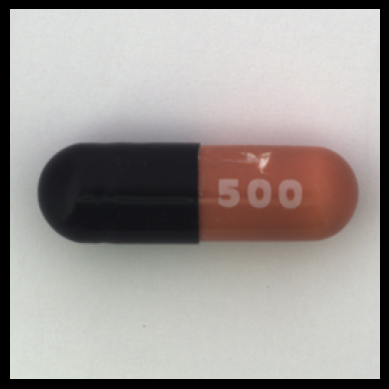

In [113]:
# Carica l'immagine
test_image_path = "../014.png"
test_img = Image.open(test_image_path).resize((256, 256))
# test_img = rotate_image_90(np.array(test_img))
# Plotta l'immagine
plt.axis('off')
plt.imshow(test_img)

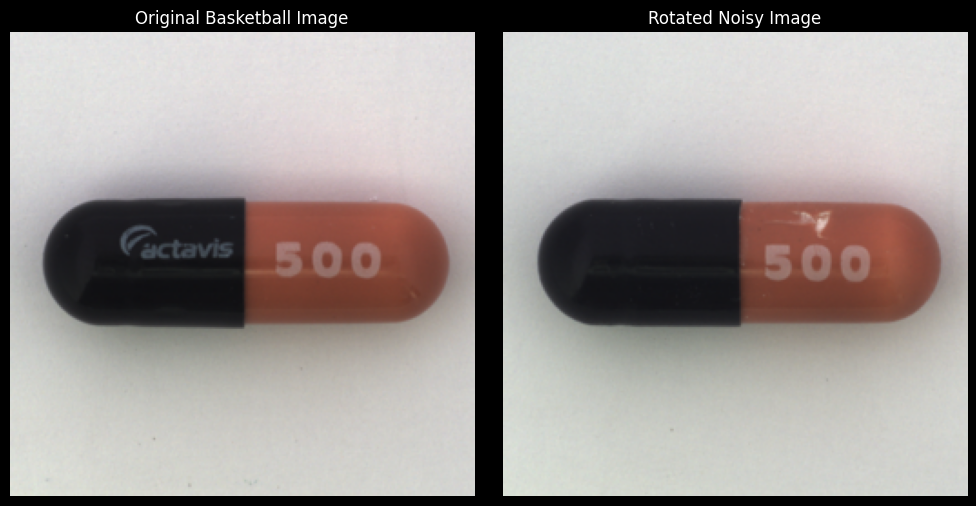

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Mostra good_img
axs[0].imshow(good_img)
axs[0].set_title("Original Basketball Image")
axs[0].axis('off')

# Mostra test_img
axs[1].imshow(test_img)
axs[1].set_title("Rotated Noisy Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [115]:
test_img_np = np.asarray(test_img)

# Prepara l'immagine come batch torch.Tensor (1, C, H, W)
test_tensor = torch.from_numpy(test_img_np.astype(np.float32)).permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    test_features = model(test_tensor)
    test_patches = extract_compact_patches(test_features, patch_size=patch_size, stride=stride, padding=padding, reduction=reduction)
    all_test_patches = test_patches.cpu()

patch_height = np.sqrt(all_test_patches.shape[0]).astype(int)
patch_width = patch_height

print(f"Total patches extracted: {len(all_test_patches)}")
print(f"Each patch is a vector of length: {all_test_patches.shape[1]} (number of channels)")
print(f"Each feature image has a shape of: {patch_height} * {patch_width} (height x width)")

Total patches extracted: 53824
Each patch is a vector of length: 100 (number of channels)
Each feature image has a shape of: 232 * 232 (height x width)


In [116]:
# Install faiss if not already installed
%pip install faiss-gpu

# Importa faiss-gpu e carica tutti i vettori contenuti in all_good_patches

# Assicurati che all_good_patches sia un torch.Tensor su CPU
if isinstance(all_good_patches, torch.Tensor):
    vectors = all_good_patches.cpu().numpy().astype('float32')
else:
    vectors = np.array(all_good_patches, dtype='float32')

print(f"Shape dei vettori caricati in FAISS: {vectors.shape}")

Note: you may need to restart the kernel to use updated packages.
Shape dei vettori caricati in FAISS: (53824, 100)


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


In [117]:
# Crea un indice L2 flat solo CPU
index = faiss.IndexFlatL2(vectors.shape[1])

# Aggiungi i vettori all'indice CPU
index.add(vectors)

print(f"Indice FAISS creato su CPU. Numero di vettori indicizzati: {index.ntotal}")

Indice FAISS creato su CPU. Numero di vettori indicizzati: 53824


In [118]:
# Seleziona una patch da all_test_patches (ad esempio la prima)
query_patch = all_test_patches[30001].numpy().astype('float32').reshape(1, -1)  # shape (1, dim)

# Esegui la ricerca dei 3 vicini più prossimi nell'indice FAISS creato su all_patches
D, I = index.search(query_patch, 3)  # D: distanze, I: indici

print("Indici dei 3 vettori più vicini:", I[0])
print("Distanze corrispondenti:", D[0])

# Visualizza i vettori trovati
for idx, (i, d) in enumerate(zip(I[0], D[0])):
    print(f"\nVicino #{idx+1} (indice {i}, distanza {d:.4f}):\n")

Indici dei 3 vettori più vicini: [28573 28804 29036]
Distanze corrispondenti: [0.09089439 0.09331743 0.09345444]

Vicino #1 (indice 28573, distanza 0.0909):


Vicino #2 (indice 28804, distanza 0.0933):


Vicino #3 (indice 29036, distanza 0.0935):



In [119]:
# Converte all_test_patches in numpy array se necessario
if isinstance(all_test_patches, torch.Tensor):
    test_vectors = all_test_patches.cpu().numpy().astype('float32')
else:
    test_vectors = np.array(all_test_patches, dtype='float32')

# Per ogni patch, cerca il vicino più vicino (k=1)
D, I = index.search(test_vectors, 1)  # D: distanze, I: indici

# D ha shape (num_patches, 1): estrai solo la colonna delle distanze
min_distances = D[:, 0]



In [120]:
min_distances.shape

(53824,)

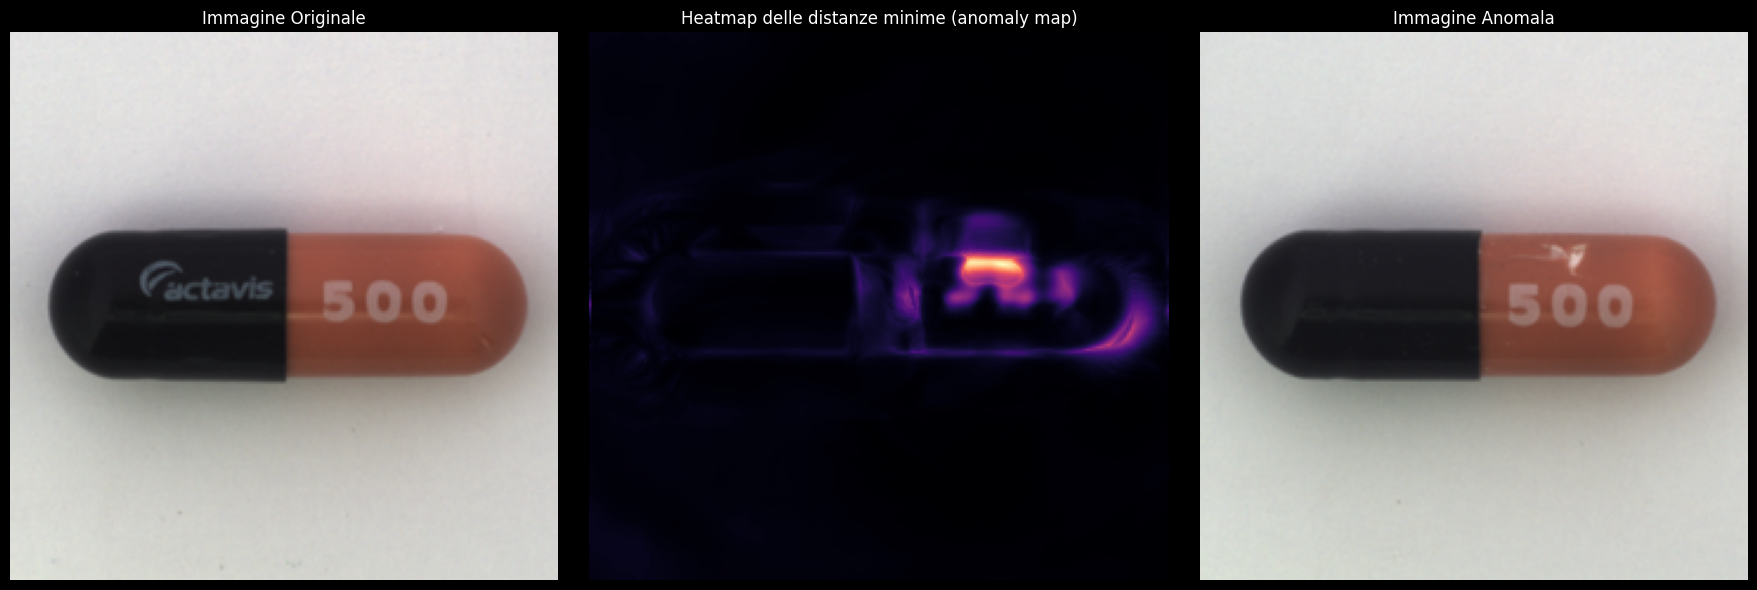

In [121]:
# Ricostruisci la mappa 2D delle distanze minime (assumendo patch_height e patch_width già definiti)
min_distances_2d = min_distances.reshape(patch_height, patch_width)

# Ridimensiona le immagini ai lati alla stessa dimensione della heatmap
target_size = (min_distances_2d.shape[1], min_distances_2d.shape[0])

# If test_img is a NumPy array, convert it to a PIL Image first
if isinstance(test_img, np.ndarray):
    test_img = Image.fromarray(test_img)
if isinstance(good_img, np.ndarray):
    good_img = Image.fromarray(good_img)
resized_good_img = good_img.resize(target_size)
resized_test_img = test_img.resize(target_size)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Immagine originale
axs[0].imshow(resized_good_img)
axs[0].set_title("Immagine Originale")
axs[0].axis('off')

# Heatmap (stessa size delle immagini)
im = axs[1].imshow(min_distances_2d, cmap='magma', aspect='auto')
axs[1].set_title('Heatmap delle distanze minime (anomaly map)')
axs[1].axis('off')
# fig.colorbar(im, ax=axs[1], shrink=0.8, label='Distanza dal vicino più vicino')

# Immagine anomala
axs[2].imshow(resized_test_img)
axs[2].set_title("Immagine Anomala")
axs[2].axis('off')

plt.tight_layout()
plt.show()